### **Import libraries**

In [ ]:
import nltk
import gdown
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### **Load and observe data**

In [ ]:
url = 'https://drive.google.com/uc?id=1EuB7Na2vvloe_ce9WYdEmb44uDMIe5k4'
output = 'Reviews.csv'
gdown.download(url, output, quiet=True)

df = pd.read_csv("Reviews.csv", parse_dates=[0])
df.info()
df.head()

<ipython-input-4-79922f3c1278>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("Reviews.csv", parse_dates=[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  object
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(4), object(6)
memory usage: 43.4+ MB


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### **Preprocess the reviews**

In [ ]:
stop_words = set(stopwords.words('english'))
# Extend the stop words list with additional words or phrases
additional_stop_words = {"br", "http", "www", "amazon", "com", "href", "gp"}

stop_words.update(additional_stop_words)

lemmatizer = WordNetLemmatizer()

def preprocess_review(review):
    # Remove special characters and digits
    review = re.sub(r'\W', ' ', review)
    review = re.sub(r'\d', ' ', review)
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['Text'].apply(preprocess_review)

### **Label the reviews**

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(review):
    sentiment = sia.polarity_scores(review)
    return sentiment

df['sentiment'] = df['cleaned_text'].apply(analyze_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x['compound'] > 0 else ('negative' if x['compound'] < 0 else 'neutral'))

### **Distribution of sentiment labels**

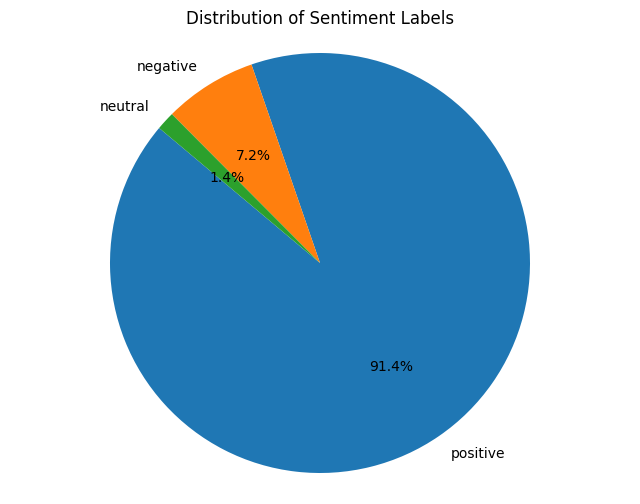

In [ ]:
sentiment_counts = df['sentiment_label'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Labels')
plt.axis('equal')
plt.show()

### **Sentiment distribution over time**

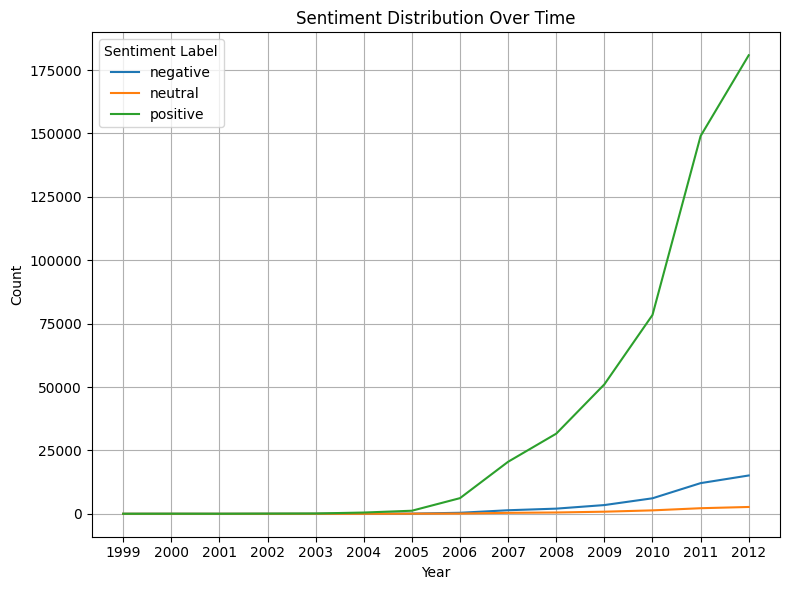

In [ ]:
# Group the data by year and sentiment_label, then count occurrences
df['Timestamp'] = pd.to_datetime(df['Time'], unit='s')
sentiment_distribution = df.groupby([df['Timestamp'].dt.year, 'sentiment_label']).size().unstack(fill_value=0)

# Plot sentiment distribution over time using a line plot
sentiment_distribution.plot(kind='line', figsize=(8, 6))
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(sentiment_distribution.index)
plt.legend(title='Sentiment Label')
plt.tight_layout()
plt.grid(True)
plt.show()


### **Distribution of review scores**

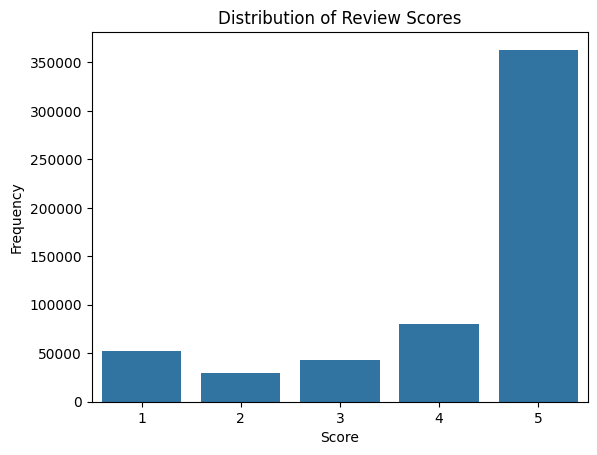

In [ ]:
sns.countplot(x='Score', data=df)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


### **Show products with the most positive and negative reviews**

In [ ]:
#ID of top 10 products with highest positive reviews
top_10_positive_products = df[df['sentiment_label'] == 'positive']['ProductId'].value_counts().head(10)
print("Top 10 Products with Highest Positive Reviews:")
print(top_10_positive_products)

#ID of top 10 products with highest negative reviews
top_10_negative_products = df[df['sentiment_label'] == 'negative']['ProductId'].value_counts().head(10)
print("\nTop 10 Products with Highest Negative Reviews:")
print(top_10_negative_products)


Top 10 Products with Highest Positive Reviews:
ProductId
B007JFMH8M    900
B003B3OOPA    598
B0026RQTGE    588
B002QWP89S    588
B002QWP8H0    588
B002QWHJOU    588
B001EO5Q64    546
B000NMJWZO    534
B001RVFEP2    526
B000VK8AVK    526
Name: count, dtype: int64

Top 10 Products with Highest Negative Reviews:
ProductId
B00004RAMY    98
B000HJ7AIY    71
B000X1Q1G8    69
B0017M5V9A    66
B006N3I69A    65
B000FBMFDO    64
B006Q820X0    61
B005K4Q34S    59
B005K4Q1YA    59
B005K4Q37A    59
Name: count, dtype: int64


### **Function to get n-grams from the reviews**

In [ ]:
def get_sorted_ngrams(reviews_df, text_column='cleaned_text', ngram_range=(3, 4), max_df=0.95, min_df=2, max_features=500):
    """
    Get sorted n-grams from the reviews dataframe based on TF-IDF scores.

    Parameters:
    - reviews_df (pd.DataFrame): DataFrame containing the reviews.
    - text_column (str): The name of the column containing the text data. Default is 'cleaned_text'.
    - ngram_range (tuple): The range of n-grams to consider. Default is (3, 4).
    - max_df (float): Maximum document frequency for the TF-IDF Vectorizer. Default is 0.95.
    - min_df (int): Minimum document frequency for the TF-IDF Vectorizer. Default is 2.
    - max_features (int): Maximum number of features for the TF-IDF Vectorizer. Default is 500.

    Returns:
    - sorted_ngrams (list): List of tuples containing n-grams and their corresponding TF-IDF scores, sorted in descending order.
    """
    # Create TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_df[text_column])

    # Get feature names and their corresponding TF-IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0)

    # Create a dictionary to map n-grams to their TF-IDF scores
    ngrams_tfidf_scores = dict(zip(feature_names, tfidf_scores.A1))

    # Sort n-grams by TF-IDF scores
    sorted_ngrams = sorted(ngrams_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

    return sorted_ngrams


### **Analyse the positive reviews**

In [ ]:
positive_reviews = df[df['sentiment_label'] == 'positive']
sorted_ngrams = get_sorted_ngrams(positive_reviews)

positive_themes = {}

for ngram, score in sorted_ngrams[:100]:
    if sia.polarity_scores(ngram)['compound'] > 0:
       positive_themes[ngram] = score

### **Display the word cloud with common positive reviews**

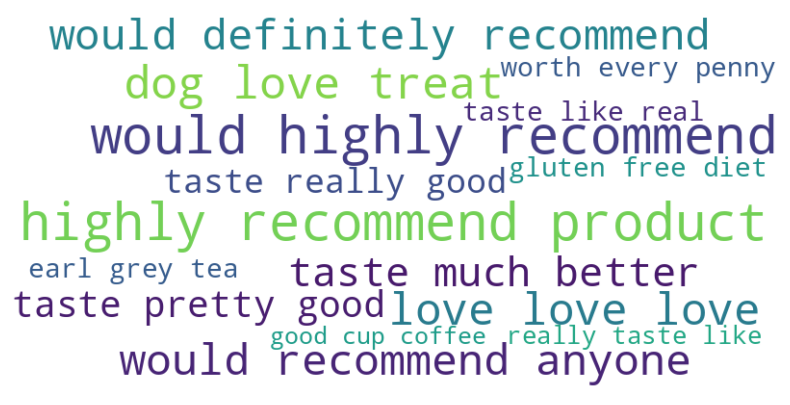

In [ ]:
top_positive_themes = {key: positive_themes[key] for idx, key in enumerate(positive_themes) if idx < 15}

# Create a word cloud from the phrases and their weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_positive_themes)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### **Analyse the negative reviews**

In [ ]:
negative_reviews = df[df['sentiment_label'] == 'negative']
sorted_ngrams = get_sorted_ngrams(negative_reviews)

negative_themes = {}

for ngram, score in sorted_ngrams[:100]:
    if sia.polarity_scores(ngram)['compound'] < 0:
       negative_themes[ngram] = score


### **Display the word cloud with common negative reviews**

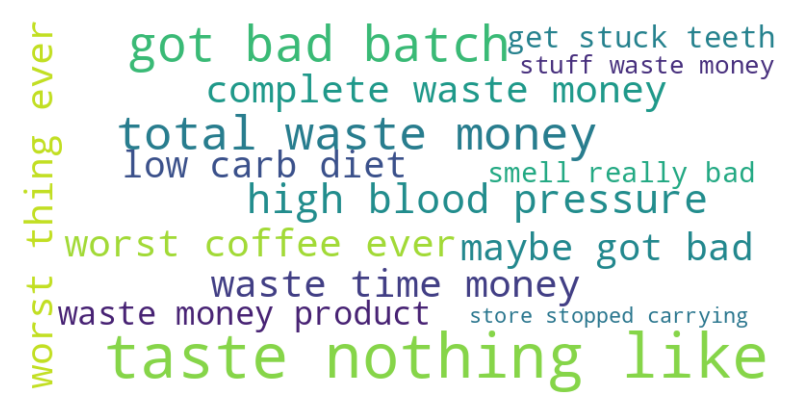

In [ ]:
top_negative_themes = {key: negative_themes[key] for idx, key in enumerate(negative_themes) if idx < 15}

# Create a word cloud from the phrases and their weights
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_negative_themes)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### **Display top concerns for N products with maximum negative reviews**

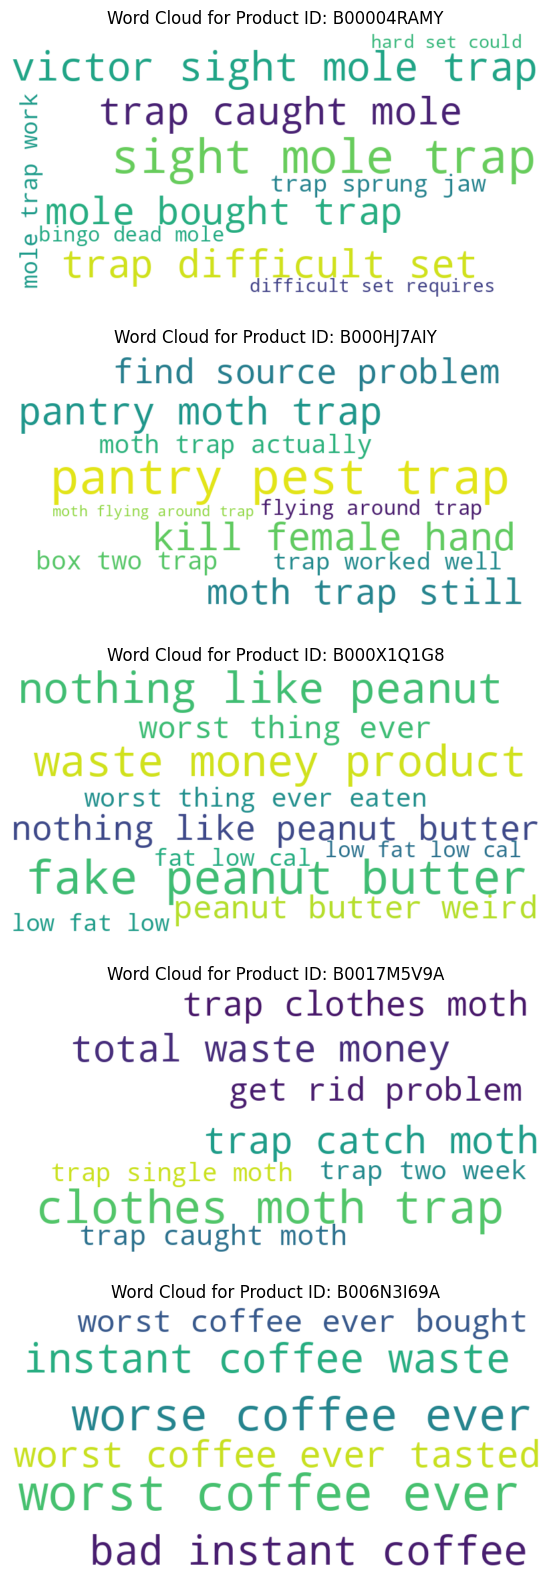

In [ ]:
def get_top_negative_products(df, top_n):
    # Filter for negative reviews and get the top N products with the highest count of negative reviews
    top_negative_products = df[df['sentiment_label'] == 'negative']['ProductId'].value_counts().head(top_n).index.tolist()
    return top_negative_products

def display_word_cloud_for_top_negative_products(df, n):
    sia = SentimentIntensityAnalyzer()
    top_negative_products = get_top_negative_products(df, top_n=n)

    # Set up subplots
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), squeeze=False)

    for idx, product_id in enumerate(top_negative_products):
        # Filter negative reviews for the current product
        product_reviews_df = df[(df['ProductId'] == product_id) & (df['sentiment_label'] == 'negative')]

        # Get sorted n-grams for the current product's reviews
        sorted_ngrams = get_sorted_ngrams(product_reviews_df)

        # Filter n-grams for negative themes
        negative_themes = {}
        for ngram, score in sorted_ngrams:
            if sia.polarity_scores(ngram)['compound'] < 0:
                negative_themes[ngram] = score

         # Ensure we only take up to top 15 negative themes
        top_negative_themes = {key: negative_themes[key] for idx, key in enumerate(sorted(negative_themes, key=negative_themes.get, reverse=True)) if idx < 10}
        #print(negative_themes)
        # Create a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_negative_themes)

        # Display the word cloud in the subplot
        axes[idx, 0].imshow(wordcloud, interpolation='bilinear')
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title(f'Word Cloud for Product ID: {product_id}')

    # Adjust space between subplots if needed
    fig.subplots_adjust(wspace=0.5)

N = 5
display_word_cloud_for_top_negative_products(df, N)
